# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.
Шаги для выбора локации обычно такие:
 - В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
 - Строят модель для предсказания объёма запасов в новых скважинах;
 - Выбирают скважины с самыми высокими оценками значений;
 - Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

In [139]:
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats as st

warnings.filterwarnings('ignore') #удаляем варнинги навсегда, очень бесят при разработке
RS = 256 # Задаем random state

In [140]:
try:
    df_0 = pd.read_csv('C:/Users/v.anufrikov/Downloads/Практикум/geo_data_0.csv')  # Локальный путь
    df_1 = pd.read_csv('C:/Users/v.anufrikov/Downloads/Практикум/geo_data_1.csv')  # Локальный путь
    df_2 = pd.read_csv('C:/Users/v.anufrikov/Downloads/Практикум/geo_data_2.csv')  # Локальный путь
except:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')  # Серверный путь
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')  # Серверный путь
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')  # Серверный путь
finally:
    print('Download complete')

Download complete


# Знакомство с данными

In [141]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [142]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [143]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Расшифровка полей df
 - id — уникальный идентификатор скважины;
 - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
 - product — объём запасов в скважине (тыс. баррелей).

Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей

 # Очистка выбросов

> Вижу что пробелов в данных нет вследствие чего можно переходить к исследованию разброса наших признаков

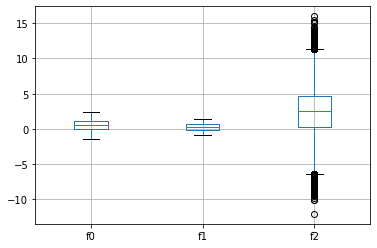

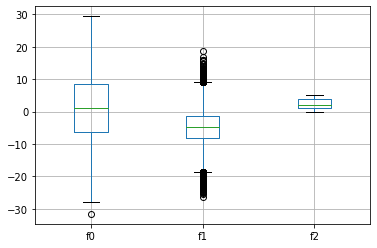

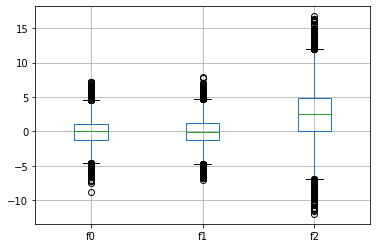

In [144]:
fields = ['f0', 'f1', 'f2']

for df in [df_0, df_1, df_2]:
    df.boxplot(column=fields)
    plt.show()

> По заданию нам необходимо напечатать на экране средний запас предсказанного сырья и RMSE модели. Проблема в том что RMSE очень не любит выбросы которые пресутсвуют у нас в выборке, поэтому я предлагаю их убрать

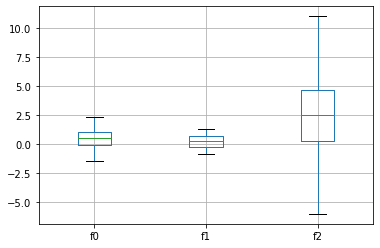

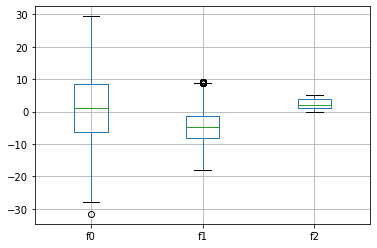

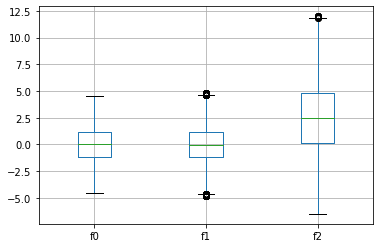

In [145]:
df_0 = df_0[(df_0['f2'] <= 11) & (df_0['f2'] >= -6)]
df_1 = df_1[(df_1['f1'] <= 9) & (df_1['f1'] >= -18)]
df_2 = df_2[(df_2['f0'] <= 4.5) & (df_2['f0'] >= -4.5) & (df_2['f1'] <= 4.8) & (df_2['f1'] >= -4.8) & (df_2['f2'] <= 12) & (df_2['f2'] >= -6.5)]

# Проверим, что все ок
for df in [df_0, df_1, df_2]:
    df.boxplot(column=fields)
    plt.show()

> Проверим, что не удалили много лишнего

In [146]:
for df in [df_0, df_1, df_2]:
    df.reset_index(inplace=True)
    print(df.count())

index      99249
id         99249
f0         99249
f1         99249
f2         99249
product    99249
dtype: int64
index      99194
id         99194
f0         99194
f1         99194
f2         99194
product    99194
dtype: int64
index      97789
id         97789
f0         97789
f1         97789
f2         97789
product    97789
dtype: int64


> Мы подготовили наше датасет к разбивке и теперь спокойно можем разбить его на выбрки 75 - 25 без тестовой выборки, я все таки думаю что id можно убрать из нашего датасета, потому что у нас нет задачи понять где конкретно нам копать, нам нужно узнать лишь регион где мы будем копать в первую очередь, а эти регионы находятся в разных датасетах

# Делим и скалируем признаки

In [147]:
def split_scaler(df, fields):

    target = df['product']
    features = df[fields]

    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                  target,
                                                                                  test_size=0.25,
                                                                                  random_state=RS,
                                                                                  shuffle=True)
    # Инициализация scaler
    scaler = StandardScaler().fit(features_train[fields])

    features_train[fields] = scaler.transfoСкаrm(features_train[fields])
    features_valid[fields] = scaler.transform(features_valid[fields])

    features_train.boxplot(column=fields)

    return features_train, features_valid, target_train, target_valid


> Рабиваем и нормализуем даные, чтобы не перепутать данные о регионах предлагаю для удобства их как то обозвать, например 1 - Москва, 2 - Санкт Петербург, 3 - Казань.


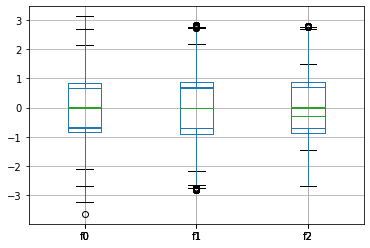

In [148]:
features_train_msk, features_valid_msk, target_train_msk, target_valid_msk = split_scaler(df_0, fields)
features_train_spb, features_valid_spb, target_train_spb, target_valid_spb = split_scaler(df_1, fields)
features_train_kzn, features_valid_kzn, target_train_kzn, target_valid_kzn = split_scaler(df_2, fields)

Вспомним условия задачи

 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - При нынешних ценах один баррель сырья приносит 450 рублей дохода.
 - Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
 - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.
 - Среди них выбирают регион с наибольшей средней прибылью.

# Обучаем LinearRegression модель

In [149]:
def linear_regression_full_score(features, target, features_valid, target_valid, sity):
    model = LinearRegression(n_jobs = -1).fit(features,
                                              target)

    predict = model.predict(features_valid)

    print(f'Sity =  {sity}')
    print(f'mse =   {np.round(mean_squared_error(target_valid, predict), 2)}')
    print(f'rmse =  {np.round(np.sqrt(mean_squared_error(target_valid, predict)), 2)}')
    print(f'r2 =    {np.round(r2_score(target_valid, predict), 2)}')
    print(f'mae =   {np.round(mean_absolute_error(target_valid, predict), 2)}')
    print(f'predicted_mean = {np.round(predict.mean(), 2)}')

    #Сохраняем результаты обучения
    sity.append('mse')
    sity.append(np.round(mean_squared_error(target_valid, predict), 2))
    sity.append('rmse')
    sity.append(np.round(np.sqrt(mean_squared_error(target_valid, predict)), 2))
    sity.append('r2')
    sity.append(np.round(r2_score(target_valid, predict), 2))
    sity.append('mae')
    sity.append(np.round(mean_absolute_error(target_valid, predict), 2))
    sity.append('predicted_mean')
    sity.append(np.round(predict.mean(), 2))

    return predict


# Смотрим на метрики и считаем прибль

In [150]:
Moscow = ['Moscow']

predict_msk = linear_regression_full_score(features_train_msk,
                                           target_train_msk,
                                           features_valid_msk,
                                           target_valid_msk,
                                           Moscow)

Sity =  ['Moskow']
mse =   1430.2
rmse =  37.82
r2 =    0.27
mae =   31.15
predicted_mean = 92.5


In [151]:
Saint_petersburg = ['Saint Petersburg']

predict_spb = linear_regression_full_score(features_train_spb,
                                           target_train_spb,
                                           features_valid_spb,
                                           target_valid_spb,
                                           Saint_petersburg)

Sity =  ['Saint Petersburg']
mse =   0.8
rmse =  0.89
r2 =    1.0
mae =   0.72
predicted_mean = 68.99


In [152]:
Kazan = ['Kazan']

predict_kzn = linear_regression_full_score(features_train_kzn,
                                           target_train_kzn,
                                           features_valid_kzn,
                                           target_valid_kzn,
                                           Kazan)

Sity =  ['Kazan']
mse =   1608.68
rmse =  40.11
r2 =    0.2
mae =   32.91
predicted_mean = 94.8


# Зададим параметры для расчета прибыли

In [153]:
points_count_explore = 500   # при разведке региона исследуют 500 точек
points_count_profit = 200    # с помощью машинного обучения выбирают 200 лучших для разработки.
budget = 10000000000         # бюджет на разработку скважин в регионе
barrel = 450
price_1h_barrel = barrel * 1000 # стоимость 1к барелей
loss_limit = 2.5             # предельная вероятность убытков

print(f'Достаточный объём сырья для безубыточной разработки региона {budget / price_1h_barrel}')
print(f'Достаточный объём сырья для безубыточной разработки скважины {(budget / price_1h_barrel) / points_count_profit}')

Достаточный объём сырья для безубыточной разработки региона 22222.222222222223
Достаточный объём сырья для безубыточной разработки скважины 111.11111111111111


> Создадим функцию расчета прибыли в каждом регионе

In [154]:
def calculate_profit(target, probabilities):

    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:points_count_profit]

    return selected.sum() * price_1h_barrel - budget

In [155]:
print(f'Модель профита для региона Москва = {calculate_profit(target_valid_msk, pd.Series(data=predict_msk, index=target_valid_msk.index))}');

Модель профита для региона Москва = 3307849735.5356426


In [156]:
print(f'Модель профита для региона Санк-Петербург = {calculate_profit(target_valid_spb, pd.Series(data=predict_spb, index=target_valid_spb.index))}');

Модель профита для региона Санк-Петербург = 2415086696.681511


In [157]:
print(f'Модель профита для региона Казань = {calculate_profit(target_valid_kzn, pd.Series(data=predict_kzn, index=target_valid_kzn.index))}');

Модель профита для региона Казань = 2584016405.6824417


> Хм, для безубыточной разаботки скважин нам необходимо 111 тысяч едениц продукта, но стредние показатели ниже этого значени
> При этом мы будем иметь хорошую прибль при разработке каждого регона

# Бустрап наших вычислений

In [158]:
def bootstrap(target, probabilities):

    state = np.random.RandomState(RS)# берем еще раз наш random state
    values = []
    alpha = .95


    for _ in range(1000): # создаем 1к выборок
        target_subsample = target.sample(n=points_count_explore,
                                         replace=True,
                                         random_state=state) # семплируем данные

        probs_subsample = probabilities[target_subsample.index]
        values.append(calculate_profit(target_subsample, probs_subsample))

    values = pd.Series(values)
    df = values.count() - 1

    print(f"Средняя прибыль: {values.mean()}")
    print(f"95% доверительный интервал истина   {st.t.interval(alpha, df, loc=values.mean(), scale=values.sem())}")
    print(f"95% доверительный интервал прогноз  {(values.quantile(0.025), values.quantile(0.975))}")
    print('Вероятность убытка = {:.2%}'.format(values[values < 0].count() / values.count()))

    if ((values[values < 0].count() / values.count()) <= loss_limit):
        print('Регион годится для разработки!')
    else:
        print('Регион не годится для разработки!')

In [159]:
print(f'Модель для региона Москва');
bootstrap(target_valid_msk, pd.Series(data=predict_msk, index=target_valid_msk.index))

Модель для регона Москва
Средняя прибыль: 451330874.1234696
95% доверительный интервал истина   (435130002.4989569, 467531745.74798226)
95% доверительный интервал прогноз  (-70284544.32363236, 966143215.9121792)
Вероятность убытка = 3.70%
Регион годится для разработки!


In [160]:
print(f'Модель для региона Санкт-Петербург');
bootstrap(target_valid_spb, pd.Series(data=predict_spb, index=target_valid_spb.index))

Модель для регона Санкт-Петербург
Средняя прибыль: 524242557.8478282
95% доверительный интервал истина   (510774883.32684886, 537710232.3688076)
95% доверительный интервал прогноз  (122907775.42348129, 938782986.8481894)
Вероятность убытка = 0.70%
Регион годится для разработки!


In [161]:
print(f'Модель для региона Казань');
bootstrap(target_valid_kzn, pd.Series(data=predict_kzn, index=target_valid_kzn.index))

Модель для регона Казань
Средняя прибыль: 350326334.91138846
95% доверительный интервал истина   (333136419.17795104, 367516250.6448259)
95% доверительный интервал прогноз  (-221447424.4918833, 884772454.0329998)
Вероятность убытка = 10.10%
Регион годится для разработки!


> В каждом регионе достаточно нефти для разработки в каждом регионе, однако лучше всего выбрать регион СПБ так ка там самая низкая вероятность убытка всего 0.70% что не может радовать(исходя из условия задачи это 2ой регион)

# Вывод

- Я изучил даные из выгрузок по 3м регионам и избавился от сильных выбросов которые смог обнаружить через boxplot, так как это могло сильно сказаться на метрике RMSE которую нам нужно испольховать по заданию
- Признаки перед обучением были стандартизированны и данные были разделены с помошью простой самописной функции(обратите внимание мы делали fit только на тренировочной выборке)
- Далее мы обучили LinearRegression, выбрали ее из за того что очень легко интерпретировать результаты модели, плюс сохранили прогнозы для дальнейшего анализа
- По условию задачи нам необходимо было рачитать прибыль при условии что барель нефти будет стоит 450 рублей, на основании этого мы взяли бюджет для разработки и расчитали прибыльность по каждому из 3х регионов
    - В итоге разарботка каждого региона спокойно покрывала наши бюджеты и каждый регион был прибыльным
- Дополнительно чтобы проверить наши выводы по прибыльности регинов мы применили бустрап в котором поедлили нашу выборку чтобы оценить регион полностью и получить средние значения

После дополнительной проверки бустрапом стало ясно что имеет смысл разрабатывать второй регион(Санкт-Петербург), так как он обеспечит высокую прибль и при этом имеет минимальный риск, дальше можно попробовать регион 1(Москва) и регион 3(Казань)